In [1]:
#Utility
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS as wc_stp

#Sklearn
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer as tvect
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn . decomposition import PCA
##Metrics and Testing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
##Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('datasets/final_bullying_dataset.csv')

In [3]:
#Under-Sampling to rebalance the dataset
#df.loc[df['oh_label'] == 1.0].count()
dfA = df.loc[df['oh_label'] == "Not Bullying"]
dfB = df.loc[df['oh_label'] == "Bullying"]

dfA = dfA.sample(n=6000)
dfB = dfB.sample(n=5700)

df = pd.concat([dfA,dfB])

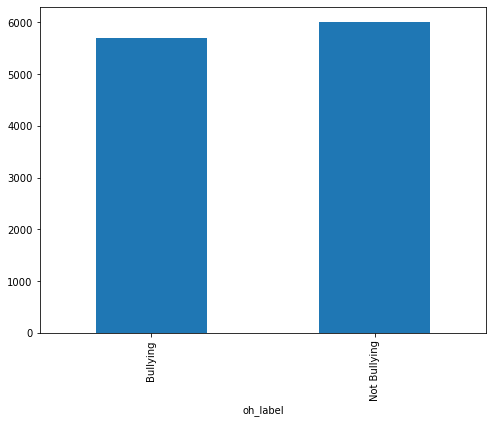

In [4]:
#Exploring the data
fig = plt.figure(figsize=(8,6))
df.groupby('oh_label').Text.count().plot.bar(ylim=0)
plt.show()

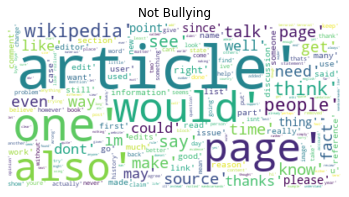

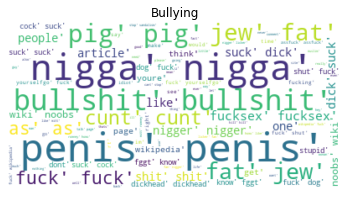

In [5]:
for class_name in ["Not Bullying","Bullying"]:
    text = ""
    df_wc = df.loc[df['oh_label'] == class_name]
    
    text = " ".join(str(x) for x in df_wc["Text"])
    
    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white").generate(text)
    
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(class_name)
    plt.show()
    
    df_wc.head()

In [6]:
#Term Frequency Inverse Document Frequency vectorization applied to append numerical values to the text based on 
#relevance to the document.
tv = tvect(min_df=.005, ngram_range=(1,2))
X = df['Text']
X = tv.fit_transform(X)
y = df['oh_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

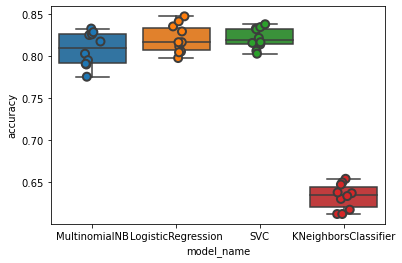

<Figure size 1800x720 with 0 Axes>

model_name
KNeighborsClassifier    0.632906
LogisticRegression      0.820256
MultinomialNB           0.808120
SVC                     0.821111
Name: accuracy, dtype: float64


In [7]:
#Testing multiple models at base configuration to see which is best for the task at hand
models = [
    MultinomialNB(),
    LogisticRegression(),
    SVC(kernel="linear"),
    KNeighborsClassifier(n_neighbors=10)
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show(plt.figure(figsize=(25,10)))
print(cv_df.groupby('model_name').accuracy.mean())

In [40]:
X = df['Text']
#Crossfold Validation for SVC and tf-idf to tune for hyperparameters
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.77, random_state=171340)

pipeline = Pipeline([
    ('tv', tvect()),
    ('svc', SVC()),
])

params = {
    'tv__max_df': [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.85,0.9],
    'tv__min_df': [1,10,100],
    'tv__ngram_range': ((1, 2), (1, 3)),
    "svc__kernel": ["linear", "poly"],
    "svc__C": [1,2,3,4,5,6,7,8,9,10]
}

grid_search = GridSearchCV(pipeline, params, verbose=1,n_jobs=-1, cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(params)

grid_search.fit(X_train, y_train)
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tv', 'svc']
parameters:
{'tv__max_df': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.85, 0.9], 'tv__min_df': [1, 10, 100], 'tv__ngram_range': ((1, 2), (1, 3)), 'svc__kernel': ['linear', 'poly'], 'svc__C': [1, 10]}
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.0min finished



Best score: 0.814
Best parameters set:
	svc__C: 1
	svc__kernel: 'linear'
	tv__max_df: 0.2
	tv__min_df: 1
	tv__ngram_range: (1, 3)


In [9]:
X = df['Text']
#Crossfold Validation for LogisticRegression and tf-idf to tune for hyperparameters
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.77, random_state=171340)

pipeline = Pipeline([
    ('tv', tvect()),
    ('lr', LogisticRegression()),
])

params = {
    'tv__max_df': [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.85,0.9],
    'tv__min_df': [1,10,100],
    'tv__ngram_range': ((1, 2), (1, 3)),
    "lr__solver": ['lbfgs', 'liblinear'],
    "lr__C": [100, 10, 1]
}

grid_search = GridSearchCV(pipeline, params, verbose=1,n_jobs=-1, cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(params)

grid_search.fit(X_train, y_train)
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tv', 'lr']
parameters:
{'tv__max_df': [0.7, 0.75, 0.8, 0.85, 0.9], 'tv__min_df': [1, 10, 100], 'tv__ngram_range': ((1, 2), (2, 2)), 'lr__solver': ['lbfgs', 'liblinear'], 'lr__C': [100, 10, 1]}
Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   17.5s finished



Best score: 0.819
Best parameters set:
	lr__C: 10
	lr__solver: 'lbfgs'
	tv__max_df: 0.7
	tv__min_df: 1
	tv__ngram_range: (1, 2)


In [10]:
X = df['Text']
#Crossfold Validation for MultinomialNB and tf-idf to tune for hyperparameters
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.77, random_state=171340)

pipeline = Pipeline([
    ('tv', tvect()),
    ('mnb', MultinomialNB()),
])

params = {
    'tv__max_df': [0.7,0.75,0.8,0.85,0.9],
    'tv__min_df': [1,10,100],
    'tv__ngram_range': ((1, 2), (2, 2)),
    "mnb__alpha": [1.0, .9, .8, .7, .6]
}

grid_search = GridSearchCV(pipeline, params, verbose=1,n_jobs=-1, cv=3)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(params)

grid_search.fit(X_train, y_train)
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tv', 'mnb']
parameters:
{'tv__max_df': [0.7, 0.75, 0.8, 0.85, 0.9], 'tv__min_df': [1, 10, 100], 'tv__ngram_range': ((1, 2), (2, 2)), 'mnb__alpha': [1.0, 0.9, 0.8, 0.7, 0.6]}
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   11.0s finished



Best score: 0.801
Best parameters set:
	mnb__alpha: 0.9
	tv__max_df: 0.7
	tv__min_df: 1
	tv__ngram_range: (1, 2)


In [41]:
#Creating the final TF-IDF Vectoriser & the final train/test set
tv = tvect(max_df=0.2,min_df=1,ngram_range=(1,3))
X = tv.fit_transform(df['Text'])
y = df['oh_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12345)

In [42]:
#Creating the final SVC Model
model = SVC(C=1,kernel='linear',probability=True)

model.fit(X_train,y_train)
print(model.score(X_test,y_test))
ypred = model.predict(X_test)

0.8352136752136752


METRICS FOR SVC
              precision    recall  f1-score   support

Not Bullying       0.88      0.77      0.82      1417
    Bullying       0.81      0.90      0.85      1508

    accuracy                           0.84      2925
   macro avg       0.84      0.83      0.83      2925
weighted avg       0.84      0.84      0.83      2925



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

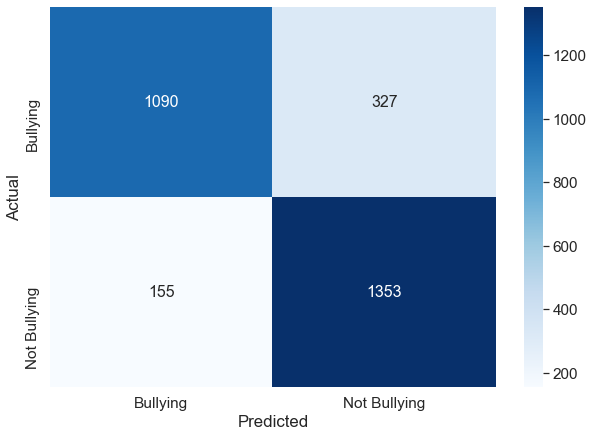

In [43]:
print("METRICS FOR SVC")
print(metrics.classification_report(y_test, ypred, target_names=df['oh_label'].unique()))
y_true = y_test
y_pred = ypred
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="g")# font size

In [14]:
#Creating the final Linear Regression Model
lr_model = LogisticRegression(C=100,solver='lbfgs')

lr_model.fit(X_train,y_train)
print(lr_model.score(X_test,y_test))
ypred = lr_model.predict(X_test)

0.8413675213675214


S:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


METRICS FOR Logistic Regression
              precision    recall  f1-score   support

Not Bullying       0.88      0.78      0.83      1417
    Bullying       0.81      0.90      0.85      1508

    accuracy                           0.84      2925
   macro avg       0.85      0.84      0.84      2925
weighted avg       0.84      0.84      0.84      2925



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

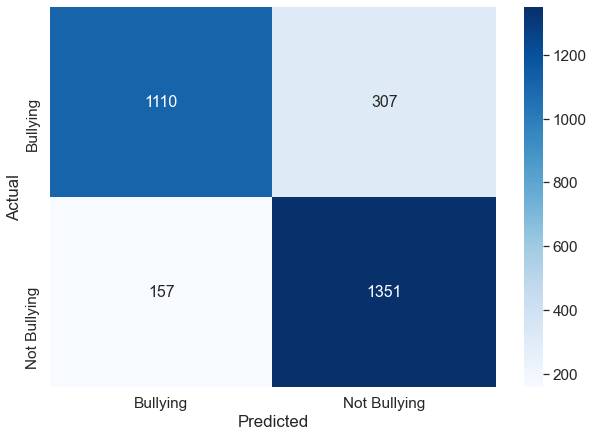

In [15]:
print("METRICS FOR Logistic Regression")
print(metrics.classification_report(y_test, ypred, target_names=df['oh_label'].unique()))
y_true = y_test
y_pred = ypred
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="g")# font size

In [16]:
#Creating the final MultinomialNB model
nb_model = MultinomialNB(alpha=0.6)

nb_model.fit(X_train,y_train)
print(nb_model.score(X_test,y_test))
ypred = nb_model.predict(X_test)

0.8338461538461538


METRICS FOR MultinomialNB
              precision    recall  f1-score   support

Not Bullying       0.85      0.79      0.82      1417
    Bullying       0.82      0.87      0.84      1508

    accuracy                           0.83      2925
   macro avg       0.84      0.83      0.83      2925
weighted avg       0.83      0.83      0.83      2925



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

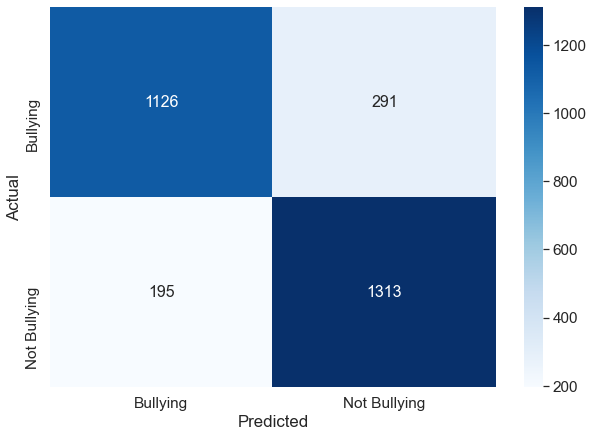

In [17]:
print("METRICS FOR MultinomialNB")
print(metrics.classification_report(y_test, ypred, target_names=df['oh_label'].unique()))
y_true = y_test
y_pred = ypred
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="g")# font size

In [18]:
print('SVC model score = ',model.score(X_test,y_test))
print('LogisticRegression model score = ',lr_model.score(X_test,y_test))
print('MultinomialNB model score = ',nb_model.score(X_test,y_test))

SVC model score =  0.8406837606837607
LogisticRegression model score =  0.8413675213675214
MultinomialNB model score =  0.8338461538461538


In [57]:
query = tv.transform(["""Because we’re British. Let that sink in"""])
predicted = model.predict(query)
print(predicted[0])
conf = model.predict_proba(query)[0]

print("Confidence [bullying] = ", conf[0] * 100)
print("Confidence [not bullying] = ", conf[1] * 100)

Not Bullying
Confidence [bullying] =  51.291844297355325
Confidence [not bullying] =  48.708155702644675
